# Trabajo Nº2 – Clasificación de Spam y No Spam con NLP

Este notebook sirve como plantilla mínima para que puedas comenzar a construir tus propios modelos de clasificación de texto.  
Incluye:
- Configuración básica e imports.
- Carga de los datasets `train.csv` y `test.csv` desde la carpeta `Spam_Data/`.
- Celda final para generar el archivo `.csv` de predicciones con el formato requerido.

Indicaciones:
- En la entrega se proporciona `Spam_Data.zip`, que contiene:
  - `train.csv` (con la columna `spam_label` como variable objetivo)
  - `test.csv` (sin etiquetas)
  - `sample_submission.csv` (ejemplo del formato del .csv)
- Descomprime el zip en el mismo directorio del notebook antes de ejecutar.
- Tú debes definir, entrenar y comparar tus modelos.
- Al final, genera `submission.csv` con el formato especificado para la entrega.

In [6]:
# Añade aquí los import que utilices en tu código
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

pd.set_option('display.max_rows', 36)
pd.set_option("display.max_colwidth", 150)
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(33)
tf.random.set_seed(33)

[nltk_data] Downloading package stopwords to /home/mike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mike/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/mike/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /home/mike/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carga de Datos

Se cargan los conjuntos **train** y **test** desde la carpeta `spam_data`, asumiendo esta estructura:

```text
Spam_Data/
├─ train.csv
├─ test.csv
├─ sample_submission.csv
```

Contenido:

- `train.csv` contiene las columnas **`row_id`**, **`text`** y **`spam_label`** (0 = NO SPAM, 1 = SPAM).
- `test.csv` contiene las columnas **`row_id`** y **`text`** (sin etiquetas).
- `sample_submission.csv` muestra el formato de entrega requerido.

Las etiquetas se almacenan como enteros:

- `0` → NO SPAM
- `1` → SPAM

In [2]:
DATASET_DIR = "Spam_Data"  # Cambia si usas otra ruta

# Cargar los archivos de train
train = pd.read_csv(f"{DATASET_DIR}/train.csv", index_col="row_id")
train

,text,spam_label
row_id,,
0,"You are everywhere dirt, on the floor, the windows, even on my shirt. And sometimes when i open my mouth, you are all that comes flowing out. I dr...",0
1,"Subject: \nmon , 24 may 2004 12 : 14 : 06 - 0600\ni am taking the liberty of writing you this\nletter instead of interrupting you\nby phone . plea...",1
2,So the sun is anti sleep medicine.,0
3,Hey are you angry with me. Reply me dr.,0
4,Ü go home liao? Ask dad to pick me up at 6...,0
...,...,...
7092,I stayed at this hotel over the weekend of the Chicago Bears Fan Convention (Feb 27- March 1). The hotel is beautiful. I had a Towers room. I had ...,0
7093,Subject: eis invoices for may\ni just wanted to make all of you aware of the message below from financial\noperations . when you review your rc re...,0
7094,Ok... The theory test? when are ü going to book? I think it's on 21 may. Coz thought wanna go out with jiayin. But she isnt free,0


In [3]:
# Cargar los archivos de test
test = pd.read_csv(f"{DATASET_DIR}/test.csv", index_col="row_id")
test

,text
row_id,
7097,"Subject: king ranch processed volumes at tailgate\nd .\nmary provided this to brian , please check against your numbers asap\n- - - - - - - - - - ..."
7098,"Subject: cialis , viagra , xanax , valium at low price ! no prescription needed !\ndiscount rx is simple , quick , and affordable ! br\noffering m..."
7099,"Subject: september deal inactivation in sitara\ncurrently , prior month deals are inactivated in sitara for portfolio\npurposes on the 10 th of th..."
7100,Subject: jan . 01 sale to texas general land office\nlinda -\ni did not know that this was part of a natural gas / crude oil exchange deal\nand bi...
7101,Subject: 5 th changes @ duke and air liquide\n- - - - - - - - - - - - - - - - - - - - - - forwarded by ami chokshi / corp / enron on 02 / 04 / 200...
...,...
11824,"Subject: contract obligations\ncharlie ,\nhere is a breakout for the volumes that have been paid on . we are off by\napproximately 20000 according..."
11825,"For a hotel rated with four diamonds by AAA, one would think the Hilton Chicago would be almost like staying at a palace with royalty. The only ro..."
11826,"We spend our days waiting for the ideal path to appear in front of us.. But what we forget is.. ""paths are made by walking.. not by waiting.."" Goo..."


## Desarrollo de la Práctica

### Preprocesamiento del texto:
Primero simplificamos las palabras para que el entrenamiento sea más eficiente.
Este procedimiento consiste en: Poner las **palabras a minúsuclas**, **quitar carácteres especiales** y **[lematizar](https://es.wikipedia.org/wiki/Lematizaci%C3%B3n)**.

In [10]:
# Inicializar herramientas de NLP
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Función para preprocesar texto:
    1. Convertir a minúsculas
    2. Eliminar caracteres especiales y números
    3. Tokenizar
    4. Eliminar stopwords
    5. Lematización
    """
    if not isinstance(text, str):
        return ""
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenizar
    tokens = word_tokenize(text)
    
    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

# Aplicar preprocesamiento
print("Preprocesando textos...")
train['cleaned_text'] = train['text'].apply(preprocess_text)
test['cleaned_text'] = test['text'].apply(preprocess_text)

# Ver ejemplos
print("\nEjemplo de texto original:")
print(train.iloc[1]['text'][:200])
print("\nEjemplo de texto preprocesado:")
print(train.iloc[1]['cleaned_text'][:200])

Preprocesando textos...

Ejemplo de texto original:
Subject: 
mon , 24 may 2004 12 : 14 : 06 - 0600
i am taking the liberty of writing you this
letter instead of interrupting you
by phone . please accept our sincere apologies for having to
decline your

Ejemplo de texto preprocesado:
subject mon may taking liberty writing letter instead interrupting phone please accept sincere apology decline gage application provide requested however recommend another company provide fixed year r


### Análisis Exploratorio:

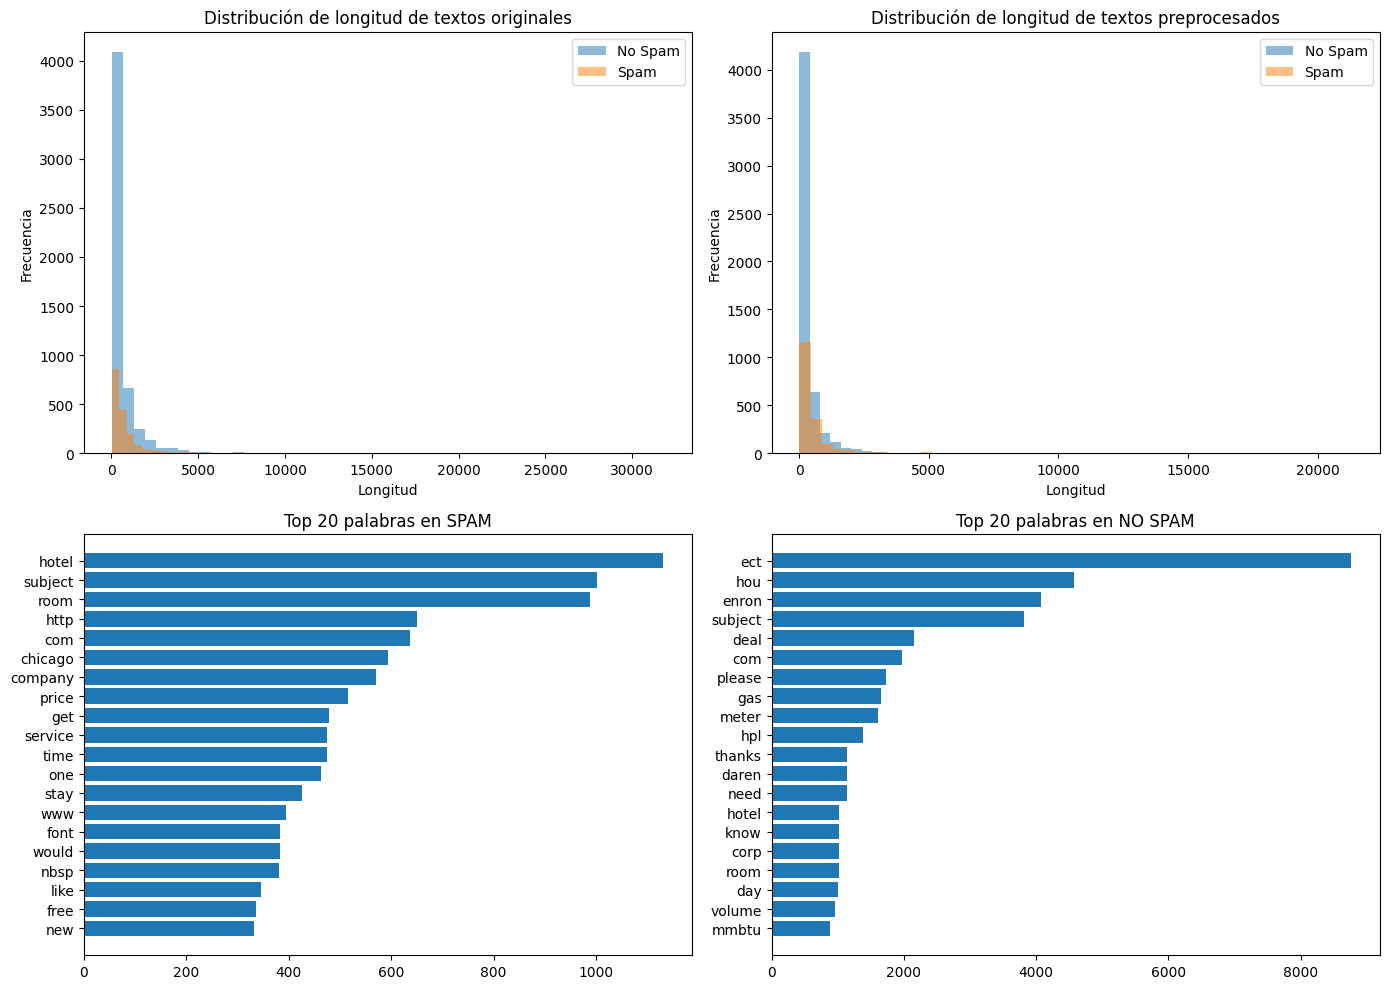

In [11]:
# Longitud de los textos
train['text_length'] = train['text'].apply(len)
train['cleaned_length'] = train['cleaned_text'].apply(len)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribución de longitudes
axes[0, 0].hist(train[train['spam_label']==0]['text_length'], bins=50, alpha=0.5, label='No Spam')
axes[0, 0].hist(train[train['spam_label']==1]['text_length'], bins=50, alpha=0.5, label='Spam')
axes[0, 0].set_title('Distribución de longitud de textos originales')
axes[0, 0].set_xlabel('Longitud')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()

axes[0, 1].hist(train[train['spam_label']==0]['cleaned_length'], bins=50, alpha=0.5, label='No Spam')
axes[0, 1].hist(train[train['spam_label']==1]['cleaned_length'], bins=50, alpha=0.5, label='Spam')
axes[0, 1].set_title('Distribución de longitud de textos preprocesados')
axes[0, 1].set_xlabel('Longitud')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()

# Palabras más frecuentes
from collections import Counter

def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

spam_texts = train[train['spam_label']==1]['cleaned_text']
ham_texts = train[train['spam_label']==0]['cleaned_text']

top_spam_words = get_top_words(spam_texts)
top_ham_words = get_top_words(ham_texts)

# Crear DataFrames para visualización
spam_df = pd.DataFrame(top_spam_words, columns=['Palabra', 'Frecuencia'])
ham_df = pd.DataFrame(top_ham_words, columns=['Palabra', 'Frecuencia'])

axes[1, 0].barh(range(len(top_spam_words)), [x[1] for x in top_spam_words])
axes[1, 0].set_yticks(range(len(top_spam_words)))
axes[1, 0].set_yticklabels([x[0] for x in top_spam_words])
axes[1, 0].set_title('Top 20 palabras en SPAM')
axes[1, 0].invert_yaxis()

axes[1, 1].barh(range(len(top_ham_words)), [x[1] for x in top_ham_words])
axes[1, 1].set_yticks(range(len(top_ham_words)))
axes[1, 1].set_yticklabels([x[0] for x in top_ham_words])
axes[1, 1].set_title('Top 20 palabras en NO SPAM')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

### Dividir en train, validation y test:

In [13]:
# Dividir datos de entrenamiento para validación
X = train['cleaned_text']
y = train['spam_label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=33, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigramas y bigramas
    min_df=5,
    max_df=0.9
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(test['cleaned_text'])

print(f"Dimensión TF-IDF: {X_train_tfidf.shape}")

Tamaño del conjunto de entrenamiento: 5677
Tamaño del conjunto de validación: 1420
Dimensión TF-IDF: (5677, 5000)


### Evaluar modelos clásicos:


Modelo: Naive Bayes
Precisión entrenamiento: 0.9260
Precisión validación: 0.8901
Matthews Correlation Coefficient: 0.7076

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1065
           1       0.78      0.78      0.78       355

    accuracy                           0.89      1420
   macro avg       0.85      0.85      0.85      1420
weighted avg       0.89      0.89      0.89      1420



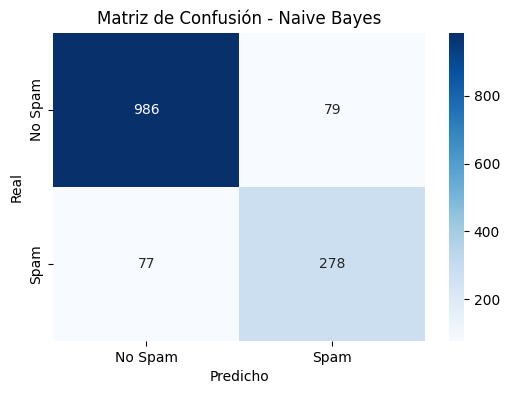


Modelo: Logistic Regression
Precisión entrenamiento: 0.9537
Precisión validación: 0.9134
Matthews Correlation Coefficient: 0.7605

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1065
           1       0.93      0.71      0.80       355

    accuracy                           0.91      1420
   macro avg       0.92      0.84      0.87      1420
weighted avg       0.91      0.91      0.91      1420



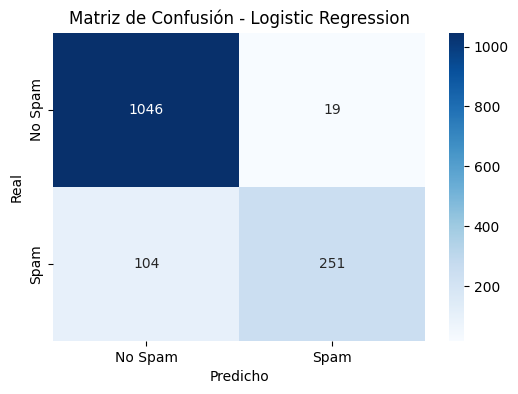


Modelo: Random Forest
Precisión entrenamiento: 0.9993
Precisión validación: 0.9254
Matthews Correlation Coefficient: 0.7953

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1065
           1       0.90      0.79      0.84       355

    accuracy                           0.93      1420
   macro avg       0.92      0.88      0.90      1420
weighted avg       0.92      0.93      0.92      1420



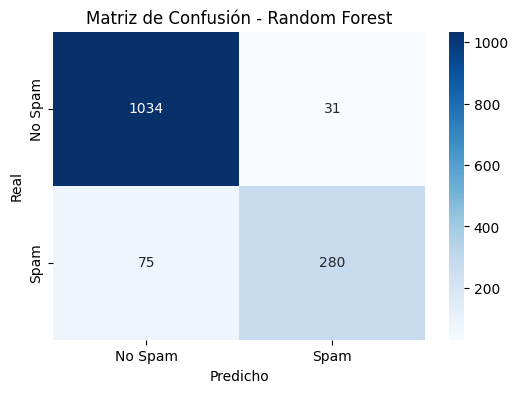


Modelo: SVM
Precisión entrenamiento: 0.9817
Precisión validación: 0.9373
Matthews Correlation Coefficient: 0.8296

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1065
           1       0.91      0.84      0.87       355

    accuracy                           0.94      1420
   macro avg       0.93      0.90      0.91      1420
weighted avg       0.94      0.94      0.94      1420



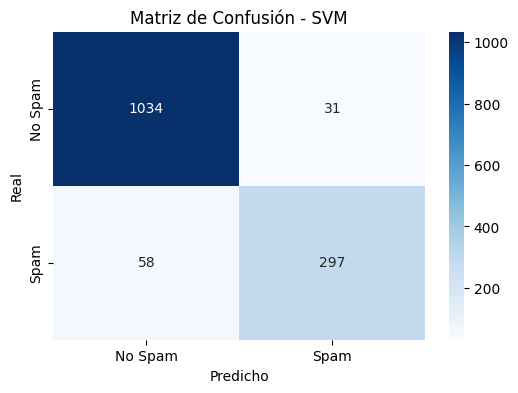

In [14]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Función para evaluar y comparar modelos"""
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Calcular métricas
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    val_mcc = matthews_corrcoef(y_val, y_pred_val)
    
    print(f"\n{'='*50}")
    print(f"Modelo: {model_name}")
    print(f"Precisión entrenamiento: {train_acc:.4f}")
    print(f"Precisión validación: {val_acc:.4f}")
    print(f"Matthews Correlation Coefficient: {val_mcc:.4f}")
    
    # Reporte de clasificación
    print("\nReporte de clasificación (validación):")
    print(classification_report(y_val, y_pred_val))
    
    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Spam', 'Spam'], 
                yticklabels=['No Spam', 'Spam'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()
    
    return model, val_acc, val_mcc

# Probar diferentes modelos
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=33),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=33),
    'SVM': SVC(kernel='linear', random_state=33)
}

results = {}
for name, model in models.items():
    trained_model, val_acc, val_mcc = evaluate_model(
        model, X_train_tfidf, y_train, X_val_tfidf, y_val, name
    )
    results[name] = {
        'model': trained_model,
        'val_accuracy': val_acc,
        'val_mcc': val_mcc
    }

/home/mike/estupidez-natural/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1765116364.696973   20889 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765116364.706502   20889 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.7936 - loss: 0.4635 - val_accuracy: 0.8577 - val_loss: 0.3084
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9309 - loss: 0.1798 - val_accuracy: 0.9282 - val_loss: 0.1849
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9727 - loss: 0.0863 - val_accuracy: 0.9423 - val_loss: 0.1750
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9889 - loss: 0.0407 - val_accuracy: 0.9415 - val_loss: 0.2239
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9910 - loss: 0.0308 - val_accuracy: 0.9387 - val_loss: 0.2423
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9952 - loss: 0.0169 - val_accuracy: 0.9401 - val_loss: 0.2623
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

Modelo: LSTM Bidireccional
Precisión validación: 0.9423
Matthews Correlation Coefficient: 0.8437

Reporte de clasificación:
              precision    recall  f1-score   support

      

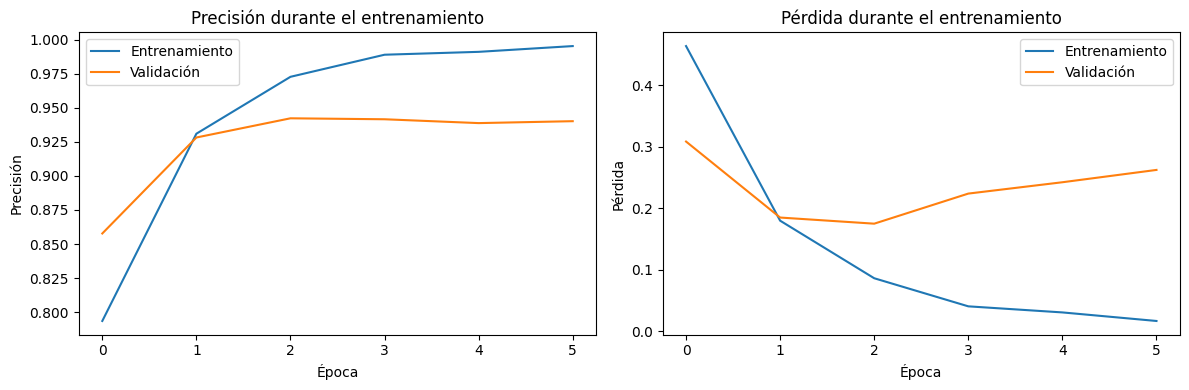

In [16]:
# Preparar datos para LSTM
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test['cleaned_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Construir modelo LSTM
def build_lstm_model():
    model = keras.Sequential([
        layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

# Entrenar modelo LSTM
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar LSTM
y_pred_lstm = (lstm_model.predict(X_val_pad) > 0.5).astype(int)
lstm_acc = accuracy_score(y_val, y_pred_lstm)
lstm_mcc = matthews_corrcoef(y_val, y_pred_lstm)

print(f"\n{'='*50}")
print("Modelo: LSTM Bidireccional")
print(f"Precisión validación: {lstm_acc:.4f}")
print(f"Matthews Correlation Coefficient: {lstm_mcc:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_val, y_pred_lstm))

# Visualizar entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Entrenamiento')
axes[0].plot(history.history['val_accuracy'], label='Validación')
axes[0].set_title('Precisión durante el entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Precisión')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Entrenamiento')
axes[1].plot(history.history['val_loss'], label='Validación')
axes[1].set_title('Pérdida durante el entrenamiento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Pérdida')
axes[1].legend()

plt.tight_layout()
plt.show()

## Generación del CSV final de Predicciones

Una vez **definido y entrenado tu modelo** (no incluido en esta plantilla) y generadas tus predicciones sobre el conjunto de prueba `test`, crea el archivo `submission.csv` con el siguiente formato:

```text
row_id,spam_label
7097,0
7098,0
7099,1
...
````

Donde:

* `row_id` es el identificador del texto en el conjunto de test.
* `spam_label` es `0` para **NO SPAM** y `1` para **SPAM**.

In [ ]:
# Cargar el archivo de ejemplo de envío
submission = pd.read_csv(f"{DATASET_DIR}/sample_submission.csv")

# Reemplazar la columna con tus predicciones
# (asegúrate de que 'y_pred' contenga las predicciones finales del modelo)
submission["spam_label"] = y_pred

# Guardar el archivo en el formato requerido
output_path = f"{DATASET_DIR}/submission.csv"
submission.to_csv(output_path, index=False)

print(f"Archivo guardado correctamente como: {output_path}")
submission.head()